## FDW Crop Production Data Analysis - Somalia

In [3]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

### Deyr-season Production

Gu-Sorghum Correlation:
            FDW     FSNAU      PRCP
FDW    1.000000  0.910159  0.346187
FSNAU  0.910159  1.000000  0.328260
PRCP   0.346187  0.328260  1.000000


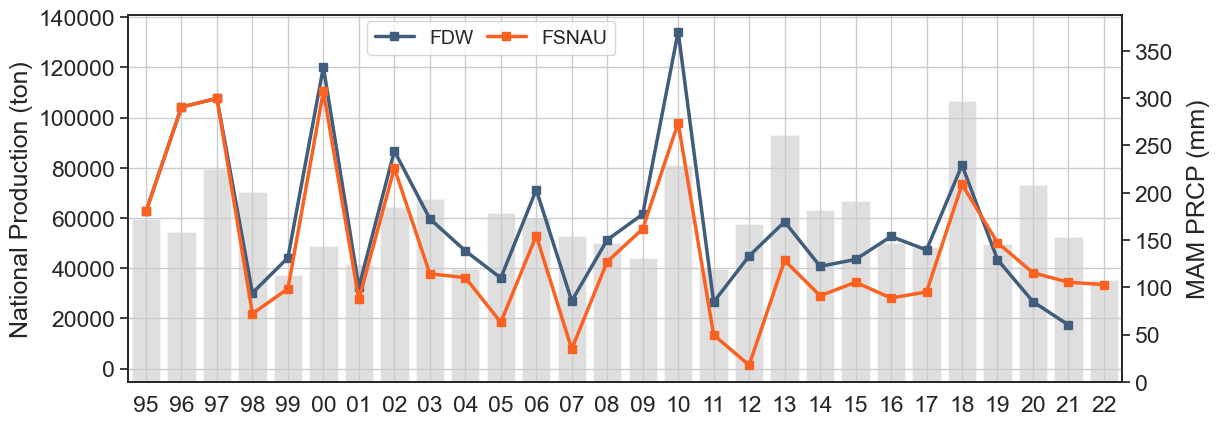

In [4]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'SO', 'Somalia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# Deyr-season
# season_name, product_name, prcp_start_month, prcp_season_name = 'Deyr', 'Sorghum', 10, 'OND PRCP (mm)'
# season_name, product_name, prcp_start_month, prcp_season_name = 'Deyr', 'Maize', 10, 'OND PRCP (mm)'
# season_name, product_name, prcp_start_month, prcp_season_name = 'Gu', 'Maize', 3, 'MAM PRCP (mm)'
season_name, product_name, prcp_start_month, prcp_season_name = 'Gu', 'Sorghum', 3, 'MAM PRCP (mm)'
df = df[
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name])) &
    (df['indicator'] == 'production')
]
df['year'] = df['planting_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FSNAU crop data ------------------------------- #
df = pd.read_csv('./public/fsnau_data_stable.csv', index_col=0)
df = df[
    (df['season_name'] == season_name) &
    (df['product'] == product_name)
]
df['year'] = df['planting_year']
data_fsnau = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FSNAU')
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fsnau], axis=1, keys=['FDW','FSNAU']).sort_index()

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name} Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1995,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

### Deyr-season Yield

Correlation:
           FDW      PRCP
FDW   1.000000  0.228043
PRCP  0.228043  1.000000


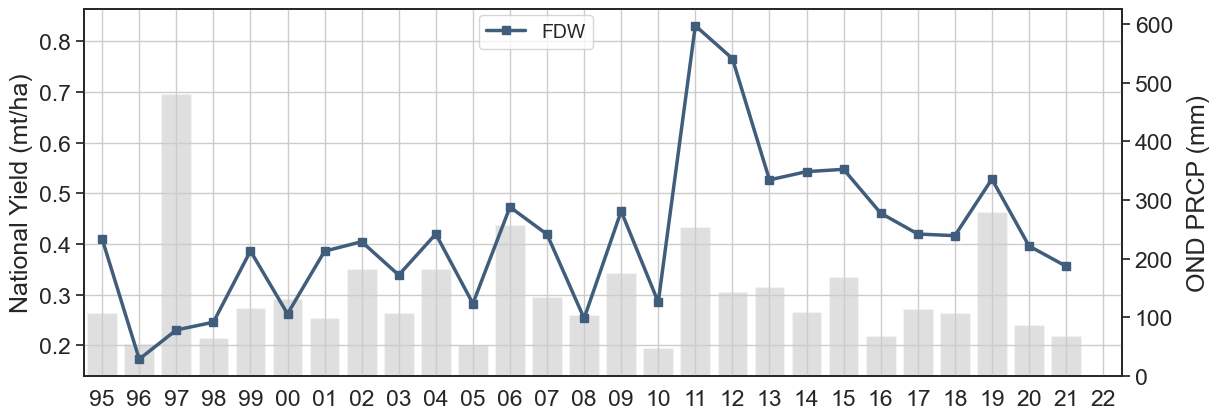

In [5]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'SO', 'Somalia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# Deyr-season
df = df[
    (df['season_name'] == 'Deyr') &
    (df['product'].isin(['Sorghum']))
]
df['year'] = df['planting_year']
df = df.pivot_table(index='year',columns='indicator',values='value',aggfunc='sum')
data = (df['production']/df['area']).rename('FDW')
# ---------------------------------------------------- #

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 10]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'OND PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1995,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Yield (mt/ha)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

### Annual Production

In [6]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'SO', 'Somalia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
product_name = 'Sorghum'
product_name_fao = 'Sorghum'
# Deyr-season
data = df[
    (df['season_name'] == 'Deyr') &
    (df['product'].isin([product_name])) &
    (df['indicator'] == 'production')
]
data['year'] = data['harvest_year']
data_deyr = data.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# Gu-season
data = df[
    (df['season_name'] == 'Gu') &
    (df['product'].isin([product_name])) &
    (df['indicator'] == 'production')
]
data['year'] = data['planting_year']
data_gu = data.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# Aggregation
data_fdw = pd.concat([data_deyr, data_gu],axis=1).sum(1).sort_index()
# ---------------------------------------------------- #

# Load FSNAU crop data ------------------------------- #
df = pd.read_csv('./public/fsnau_data_stable.csv', index_col=0)
# Deyr-season
data = df[
    (df['season_name'] == 'Deyr') &
    (df['product'] == product_name)
]
data['year'] = data['harvest_year']
data_deyr = data.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FSNAU')
# Gu-season
data = df[
    (df['season_name'] == 'Gu') &
    (df['product'] == product_name)
]
data['year'] = data['harvest_year']
data_gu = data.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FSNAU')
# Aggregation
data_fsnau = pd.concat([data_deyr, data_gu],axis=1).sum(1).sort_index()
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('./data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == 'Somalia') &
    (df['cpc2_name'] == product_name_fao) &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #

# # Load FAO-AgroMaps Subnational Production Data ------ #
# df = pd.read_csv('./data/crop/adm_fao_agromaps.csv', index_col=0, low_memory=False)
# data_fao2 = df[
#     (df['cnt_name'] == 'Somalia') &
#     (df['cpc2_name'] == 'Maize (corn)') &
#     (df['adm_level'] == 2) &
#     (df['indicator'] == 'Production')
# ].pivot_table(index='year',columns='admx_code',values='value')
# # print(data_fao2)
# # data_fao2.index = data_fao2.index - 1
# data_fao2 = data_fao2.sum(1)
# # ---------------------------------------------------- #

data = pd.concat([data_fdw, data_fsnau, data_fao], axis=1, keys=['FDW','FSNAU','FAO']).sort_index()
data.tail()

,FDW,FSNAU,FAO
year,,,
2019,103096.45,112559.45,125000.0
2020,114959.20,115797.31,100000.0
2021,41479.50,90226.65,NaN
2022,24609.00,58078.25,NaN
2023,NaN,37729.90,NaN


Annual-Sorghum Correlation:
            FDW     FSNAU       FAO      PRCP
FDW    1.000000  0.955203  0.666453  0.297390
FSNAU  0.955203  1.000000  0.659819  0.233918
FAO    0.666453  0.659819  1.000000 -0.030247
PRCP   0.297390  0.233918 -0.030247  1.000000


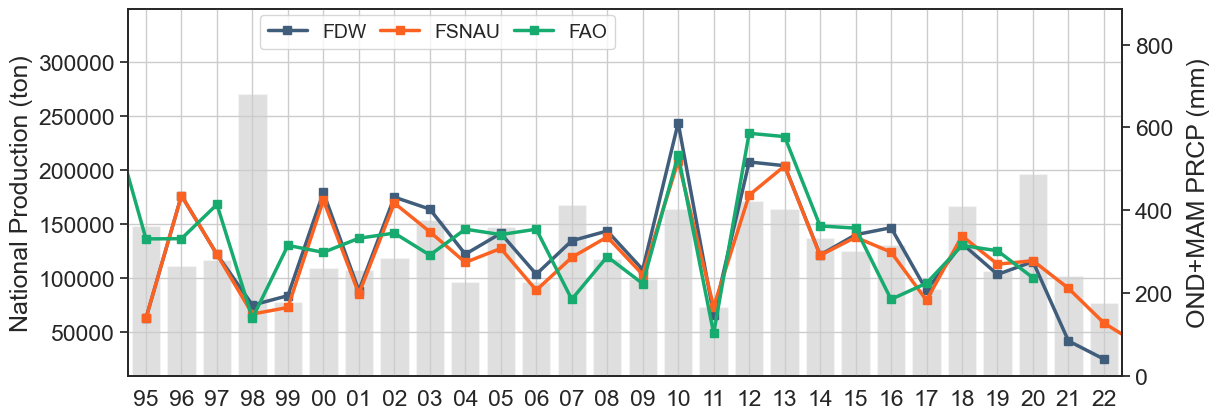

In [7]:
# Load precipitation --------------------------------- #
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat1 = prcp_nat[prcp_nat.index.month == 10]                      # Start month
prcp_nat1 = prcp_nat1.groupby(prcp_nat1.index.year).sum()
prcp_nat1.index += 1
prcp_nat2 = prcp_nat[prcp_nat.index.month == 3]                      # Start month
prcp_nat2 = prcp_nat2.groupby(prcp_nat2.index.year).sum()
prcp_nat = prcp_nat1 + prcp_nat2
prcp_nat = prcp_nat[prcp_nat.notna()]
prcp_label = 'OND+MAM PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Annual-{product_name} Correlation:\n{corr_value}')
# # ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1995,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #